## 1. Descriptive Analysis - Dataset Preparation ##

### 1a. videoTitles - translated video titels to identify "hunting" videos ###

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter

path = 'desc_title_translated.pkl'
# Open the file for reading in binary mode
with open(path, 'rb') as file:
    # Load the object from the file
    translated = pickle.load(file)

# Display the data
#translated.head(5)

In [2]:
import pandas as pd
import re

# Custom function to check for "hunt" variations
def contains_hunt(title):
    pattern = re.compile(r'\bhunt(?:s|ing|ed)?\b')
    return bool(pattern.search(title.lower()))

# Create a new column "hunt" with True/False values based on the presence of "hunt" variations in the titles
translated['hunt'] = translated['title_en'].apply(contains_hunt)

#translated.head()

In [3]:
# Count the number of occurrences of "hunt" in the "hunt" column
num_hunt_videos = sum(translated['hunt'] == True)
num_no_hunt_videos = sum(translated['hunt'] == False)

# Print the result
print(f"The number of video titles containing variations of the word 'hunt' is: {num_hunt_videos}")
print(f"The number of video titles NOT containing variations of the word 'hunt' is: {num_no_hunt_videos}")

The number of video titles containing variations of the word 'hunt' is: 334
The number of video titles NOT containing variations of the word 'hunt' is: 3561


In [4]:
hunt_videos = translated[['yt8M_id','title_en','hunt']]

### 1b. videoDets - video details, such as engagement metrics, categories, duration, etc. ###

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

path = 'videoDets.pkl'
# Open the file for reading in binary mode
with open(path, 'rb') as file:
    # Load the object from the file
    dets = pickle.load(file)

# Display the data
#dets.head()

In [6]:
dets = dets[['yt8M_id', 'snippet.title',
             'snippet.categoryId', 'snippet.publishedAt',
             'contentDetails.duration','status.madeForKids',
             'statistics.viewCount', 'statistics.likeCount', 
             'statistics.favoriteCount', 'statistics.commentCount',
            ]]
#dets.head()

In [7]:
# merge hunt_videos and dets
# Join the DataFrames on the 'yt8M_id' column
dets_hunt = dets.merge(hunt_videos, on='yt8M_id')
#dets_hunt.head(3)

### 1c. videoTitles + videoDets - merged dataset for descriptive analysis ###

In [8]:
columns4 = ['statistics.viewCount', 'statistics.likeCount', 'statistics.favoriteCount', 'statistics.commentCount']
for column in columns4:
    dets_hunt[column] = pd.to_numeric(dets_hunt[column], errors='coerce')

In [9]:
import pandas as pd

# create the dictionary mapping category IDs to category names
category_dict = {'15': 'Pets & Animals', '19': 'Travel & Events', '17': 'Sports',
                 '22': 'People & Blogs', '24': 'Entertainment', '27': 'Education',
                 '29': 'Nonprofits & Activism', '1': 'Film & Animation',
                 '28': 'Science & Technology', '25': 'News & Politics', '10': 'Music',
                 '26': 'Howto & Style', '2': 'Autos & Vehicles', '23': 'Comedy', '20': 'Gaming'}

# use the map() function to replace category IDs with category names
dets_hunt['snippet.categoryId'] = dets_hunt['snippet.categoryId'].map(category_dict)

In [10]:
import pandas as pd
import isodate

# convert the duration strings to seconds
dets_hunt['contentDetails.duration'] = dets_hunt['contentDetails.duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())

# convert snippet.publishedAt datetime strings to YYYY-MM-DD format
dets_hunt['snippet.publishedOn'] = pd.to_datetime(dets_hunt['snippet.publishedAt']).dt.strftime('%Y-%m-%d')

# display the updated dataframe
dets_hunt = dets_hunt[['yt8M_id', 'snippet.title', 'title_en', 'snippet.publishedAt', 'snippet.publishedOn','contentDetails.duration',
                       'snippet.categoryId', 'status.madeForKids',
                       'statistics.viewCount','statistics.likeCount','statistics.favoriteCount','statistics.commentCount','hunt']]

In [11]:
import json

# Open the JSON file and load its contents into a dictionary
with open('hunting_dict.json', 'r') as file:
    hunt_dict = json.load(file)
    
# Add a new column to dets_hunt with the values from the dictionary
dets_hunt['hunt_dict'] = dets_hunt['yt8M_id'].map(hunt_dict)

# Replace 1.0 with True and 0.0 with False in the hunt_dict column
dets_hunt['hunt_dict'] = dets_hunt['hunt_dict'].replace({1.0: True, 0.0: False})

# Rename the hunt column to hunt_title
##########################################
############ IMPORTANT STEP ##############
##########################################
dets_hunt = dets_hunt.rename(columns={'hunt': 'hunt_title'})

# Create a new column 'hunt' that shows True if either hunt_title or hunt_dict contain True
dets_hunt['hunt'] = dets_hunt[['hunt_title', 'hunt_dict']].any(axis=1)

In [12]:
import pandas as pd

# Create a contingency table of the overlap between hunt and hunt_dict
contingency_table = pd.crosstab(dets_hunt['hunt_title'], dets_hunt['hunt_dict'], dropna=False)

# Print the contingency table
print(contingency_table)

hunt_dict   False  True 
hunt_title              
False        3248    287
True          295     39


### 1d. Explanation of the columns ###
- 'yt8M_id': The YouTube-8M ID of the video.
- 'snippet.title': The title of the video.
- 'title_en': The title of the video - translated to English.
- 'snippet.publishedAt': The date and time when the video was published.
- 'snippet.publishedOn': The date when the video was published.
- 'contentDetails.duration': The length of the video.
- 'snippet.categoryId': The ID of the category that the video belongs to. ID has already been mapped to the actual category name for interpretation purposes.
- 'status.madeForKids': Indicates whether the video is made for kids (True/False).
- 'statistics.viewCount': The number of views the video has received.
- 'statistics.likeCount': The number of likes the video has received.
- 'statistics.favoriteCount': The number of times the video has been added to a user's favorites.
- 'statistics.commentCount': The number of comments on the video.
- 'hunt': Indicates whether the video titles includes the word 'hunt*' (True/False).

In [13]:
# Sample Columns
dets_hunt.head(2)

,yt8M_id,snippet.title,title_en,snippet.publishedAt,snippet.publishedOn,contentDetails.duration,snippet.categoryId,status.madeForKids,statistics.viewCount,statistics.likeCount,statistics.favoriteCount,statistics.commentCount,hunt_title,hunt_dict,hunt
0,HTft,Obserwator 22: Jesień na tamie / Autumn on a ...,Observer 22: Autumn on a Beaver's Dam,2014-11-05T07:49:51Z,2014-11-05,483.0,Pets & Animals,False,2415,19.0,0,3.0,False,False,False
1,VX3C,bébés ocelots et otocyons au Domaine des Fauves,Babies and Otocyons in the Domaine des Fauves,2011-11-01T06:43:23Z,2011-11-01,214.0,Pets & Animals,False,5582,27.0,0,1.0,False,False,False


## 2. Descriptive Analysis - Results ##

### 2a. Engagement Metrics ###

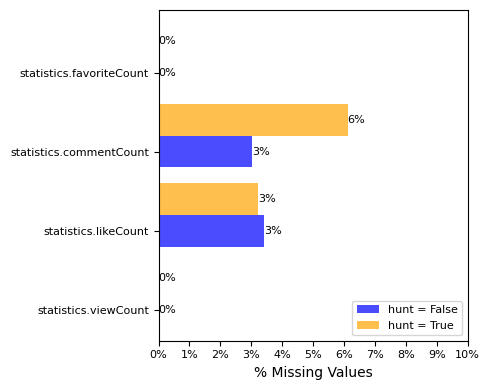

In [14]:
# Define the columns to consider
columns4 = ['statistics.viewCount', 'statistics.likeCount', 'statistics.commentCount', 'statistics.favoriteCount']

# Calculate % of NaN for each column based on the 'hunt' column
missing_data = dets_hunt[columns4].groupby(dets_hunt['hunt']).apply(lambda x: x.isna().mean()) * 100
missing_data = missing_data.transpose() # Transpose to put variable names on the y-axis

# Plot the missing data percentages
fig, ax = plt.subplots(figsize=(5, 4))

# Set the bar width
bar_width = 0.4

# Create a range of x-values for each subplot
x_false = range(len(missing_data[False]))
x_true = [i + bar_width for i in x_false]

# Plot the bars for hunt=False
rects1 = ax.barh(x_false, missing_data[False], height=bar_width, color='blue', alpha=0.7, label='hunt = False')

# Plot the bars for hunt=True
rects2 = ax.barh(x_true, missing_data[True], height=bar_width, color='orange', alpha=0.7, label='hunt = True')

# Add y-tick labels with variable names
ax.set_yticks(range(len(missing_data)))
ax.set_yticklabels(missing_data.index, fontsize=8)

# Add x-tick labels with percentages
ax.set_xlabel('% Missing Values', fontsize=10)
ax.set_xticks(range(0, 11, 1))
ax.set_xticklabels([f'{i}%' for i in range(0, 11)], fontsize=8)

# Add value labels to bars
for rect in rects1:
    width = rect.get_width()
    ax.text(width, rect.get_y() + rect.get_height() / 2, f'{int(width)}%', ha='left', va='center', fontsize=8)
for rect in rects2:
    width = rect.get_width()
    ax.text(width, rect.get_y() + rect.get_height() / 2, f'{int(width)}%', ha='left', va='center', fontsize=8)

# Move legend to lower right corner
ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

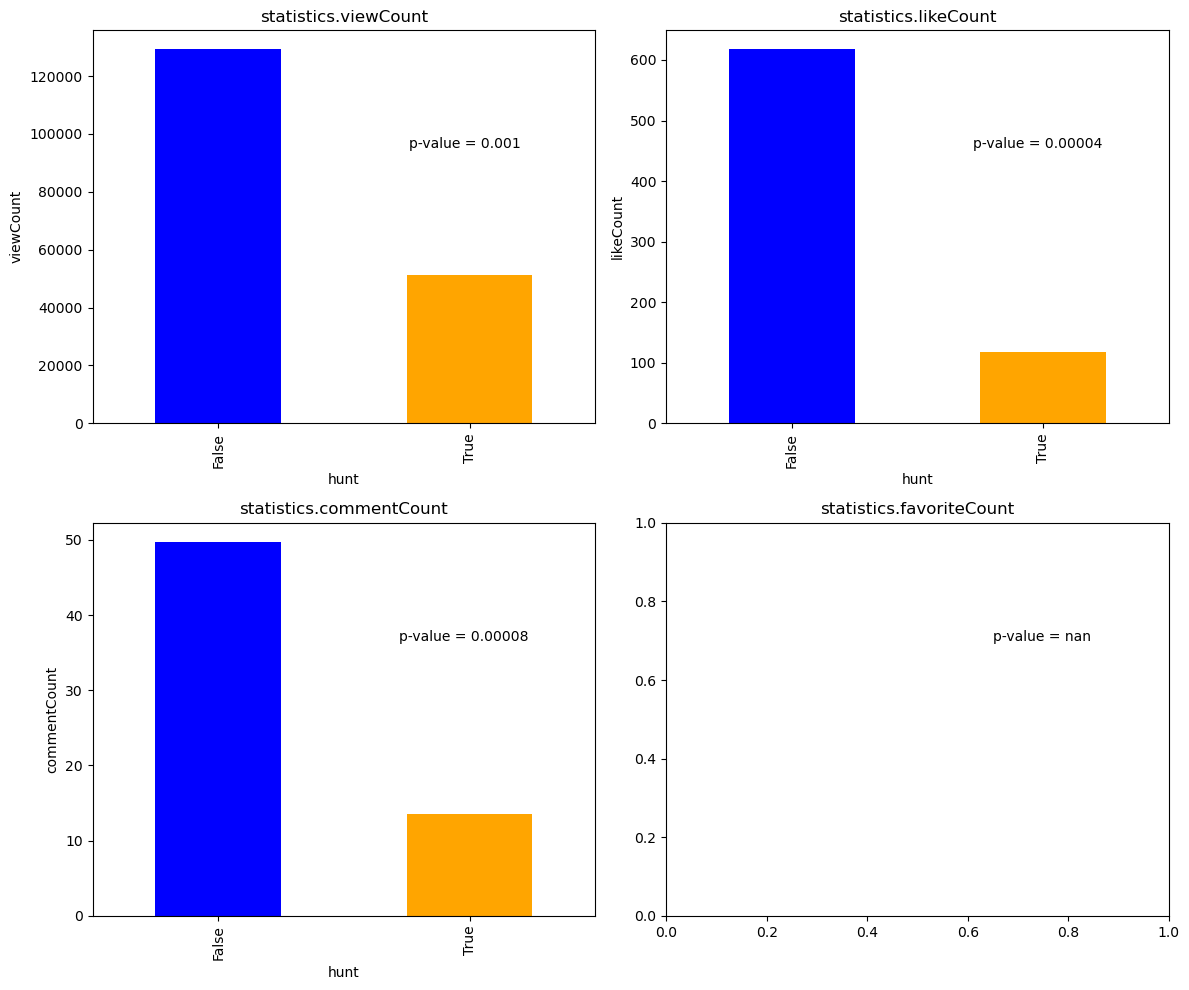

In [15]:
import scipy.stats as stats
import numpy as np

# Split the data into hunting and non-hunting videos
hunt_df = dets_hunt[dets_hunt['hunt'] == 1]
non_hunt_df = dets_hunt[dets_hunt['hunt'] == 0]

# Perform Welch's t-test for each variable
viewCount_ttest = stats.ttest_ind(hunt_df['statistics.viewCount'].dropna(), non_hunt_df['statistics.viewCount'].dropna(), equal_var=False)
likeCount_ttest = stats.ttest_ind(hunt_df['statistics.likeCount'].dropna(), non_hunt_df['statistics.likeCount'].dropna(), equal_var=False)
commentCount_ttest = stats.ttest_ind(hunt_df['statistics.commentCount'].dropna(), non_hunt_df['statistics.commentCount'].dropna(), equal_var=False)
favoriteCount_ttest = stats.ttest_ind(hunt_df['statistics.favoriteCount'].dropna(), non_hunt_df['statistics.favoriteCount'].dropna(), equal_var=False)

import matplotlib.pyplot as plt

# Convert string columns to float and create separate dataframes for each variable
df_viewCount = dets_hunt[['hunt', 'statistics.viewCount']].dropna(subset=['statistics.viewCount']).astype({'statistics.viewCount': float})
df_likeCount = dets_hunt[['hunt', 'statistics.likeCount']].dropna(subset=['statistics.likeCount']).astype({'statistics.likeCount': float})
df_commentCount = dets_hunt[['hunt', 'statistics.commentCount']].dropna(subset=['statistics.commentCount']).astype({'statistics.commentCount': float})
df_favoriteCount = dets_hunt[['hunt', 'statistics.favoriteCount']].dropna(subset=['statistics.favoriteCount']).astype({'statistics.favoriteCount': float})

# Groupby the "hunt" column and get the mean of the grouped columns
grouped_df_viewCount = df_viewCount.groupby('hunt')
mean_viewCount_df = grouped_df_viewCount['statistics.viewCount'].mean()

grouped_df_likeCount = df_likeCount.groupby('hunt')
mean_likeCount_df = grouped_df_likeCount['statistics.likeCount'].mean()

grouped_df_commentCount = df_commentCount.groupby('hunt')
mean_commentCount_df = grouped_df_commentCount['statistics.commentCount'].mean()

grouped_df_favoriteCount = df_favoriteCount.groupby('hunt')
mean_favoriteCount_df = grouped_df_favoriteCount['statistics.favoriteCount'].mean()

# Define the colors for the bars based on the 'hunt' value
colors = ['blue', 'orange']

# Create a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot the viewCount column on its own subplot
axs[0, 0].set_title('statistics.viewCount', fontsize=12)
axs[0, 0].tick_params(axis='both', which='major', labelsize=10)
axs[0, 0].set_xlabel('hunt', fontsize=10)
axs[0, 0].set_ylabel('viewCount', fontsize=10)
mean_viewCount_df.plot(kind='bar', ax=axs[0, 0], color=[colors[hunt] for hunt in mean_viewCount_df.index])
axs[0, 0].text(0.63, 0.7, 'p-value = {:.3f}'.format(viewCount_ttest.pvalue), transform=axs[0, 0].transAxes)

# Plot the likeCount column on its own subplot
axs[0, 1].set_title('statistics.likeCount', fontsize=12)
axs[0, 1].tick_params(axis='both', which='major', labelsize=10)
axs[0, 1].set_xlabel('hunt', fontsize=10)
axs[0, 1].set_ylabel('likeCount', fontsize=10)
mean_likeCount_df.plot(kind='bar', ax=axs[0, 1], color=[colors[hunt] for hunt in mean_likeCount_df.index])
axs[0, 1].text(0.61, 0.7, 'p-value = {:.5f}'.format(likeCount_ttest.pvalue), transform=axs[0, 1].transAxes)

# Plot the commentCount column on its own subplot
axs[1, 0].set_title('statistics.commentCount', fontsize=12)
axs[1, 0].tick_params(axis='both', which='major', labelsize=10)
axs[1, 0].set_xlabel('hunt', fontsize=10)
axs[1, 0].set_ylabel('commentCount', fontsize=10)
mean_commentCount_df.plot(kind='bar', ax=axs[1, 0], color=[colors[hunt] for hunt in mean_commentCount_df.index])
axs[1, 0].text(0.61, 0.7, 'p-value = {:.5f}'.format(commentCount_ttest.pvalue), transform=axs[1, 0].transAxes)

# Plot the favoriteCount column on its own subplot
axs[1, 1].set_title('statistics.favoriteCount', fontsize=12)
axs[1, 0].tick_params(axis='both', which='major', labelsize=10)
axs[1, 0].set_xlabel('hunt', fontsize=10)
axs[1, 0].set_ylabel('commentCount', fontsize=10)
mean_commentCount_df.plot(kind='bar', ax=axs[1, 0], color=[colors[hunt] for hunt in mean_commentCount_df.index])
axs[1, 1].text(0.65, 0.7, 'p-value = {:.5f}'.format(favoriteCount_ttest.pvalue), transform=axs[1, 1].transAxes)

plt.tight_layout()
plt.show()

### 2b. Engagement Metrics - Correlation ###

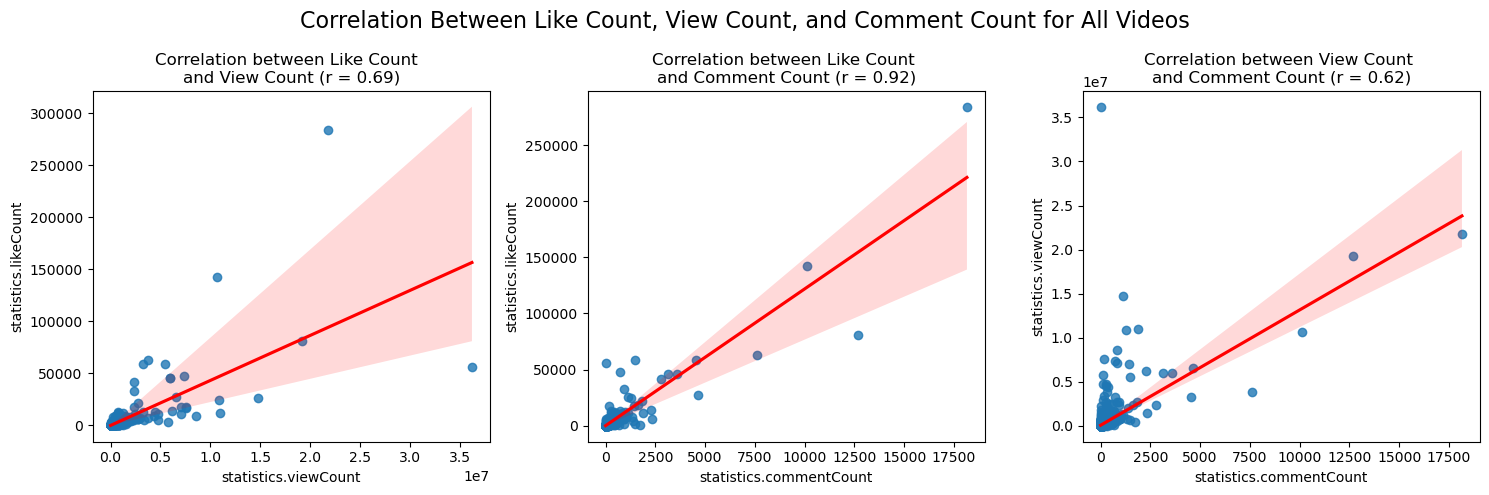

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation coefficients
corr1 = dets_hunt['statistics.likeCount'].corr(dets_hunt['statistics.viewCount'])
corr2 = dets_hunt['statistics.likeCount'].corr(dets_hunt['statistics.commentCount'])
corr3 = dets_hunt['statistics.viewCount'].corr(dets_hunt['statistics.commentCount'])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plot with regression line and correlation coefficient for Like Count and View Count
sns.regplot(ax=axes[0], x='statistics.viewCount', y='statistics.likeCount', data=dets_hunt, line_kws={'color': 'red'})
axes[0].set_title('Correlation between Like Count  \nand View Count (r = {:.2f})'.format(corr1))

# Plot scatter plot with regression line and correlation coefficient for Like Count and Comment Count
sns.regplot(ax=axes[1], x='statistics.commentCount', y='statistics.likeCount', data=dets_hunt, line_kws={'color': 'red'})
axes[1].set_title('Correlation between Like Count \nand Comment Count (r = {:.2f})'.format(corr2))

# Plot scatter plot with regression line and correlation coefficient for View Count and Comment Count
sns.regplot(ax=axes[2], x='statistics.commentCount', y='statistics.viewCount', data=dets_hunt, line_kws={'color': 'red'})
axes[2].set_title('Correlation between View Count \nand Comment Count (r = {:.2f})'.format(corr3))

# Add overarching title
plt.suptitle('Correlation Between Like Count, View Count, and Comment Count for All Videos', fontsize=16)

# Display plots
plt.tight_layout()
plt.show()

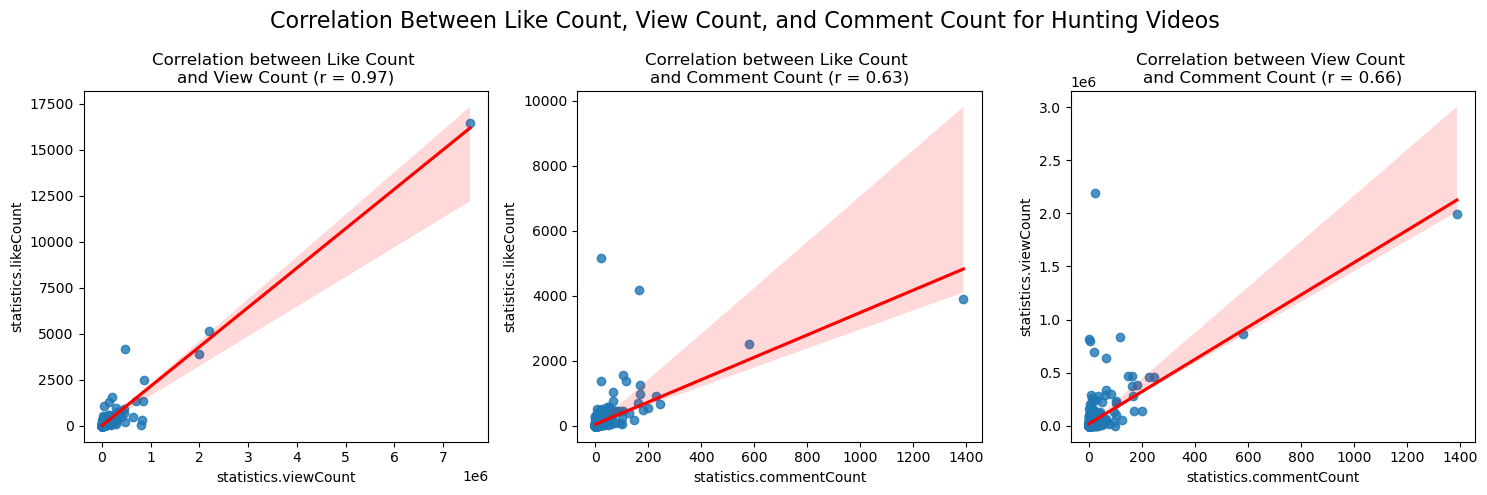

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data points where 'hunt' is True
dets_hunt_true = dets_hunt[dets_hunt['hunt'] == True]

# Calculate correlation coefficients for filtered data
corr1 = dets_hunt_true['statistics.likeCount'].corr(dets_hunt_true['statistics.viewCount'])
corr2 = dets_hunt_true['statistics.likeCount'].corr(dets_hunt_true['statistics.commentCount'])
corr3 = dets_hunt_true['statistics.viewCount'].corr(dets_hunt_true['statistics.commentCount'])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plot with regression line and correlation coefficient for Like Count and View Count
sns.regplot(ax=axes[0], x='statistics.viewCount', y='statistics.likeCount', data=dets_hunt_true, line_kws={'color': 'red'})
axes[0].set_title('Correlation between Like Count \nand View Count (r = {:.2f})'.format(corr1))

# Plot scatter plot with regression line and correlation coefficient for Like Count and Comment Count
sns.regplot(ax=axes[1], x='statistics.commentCount', y='statistics.likeCount', data=dets_hunt_true, line_kws={'color': 'red'})
axes[1].set_title('Correlation between Like Count \nand Comment Count (r = {:.2f})'.format(corr2))

# Plot scatter plot with regression line and correlation coefficient for View Count and Comment Count
sns.regplot(ax=axes[2], x='statistics.commentCount', y='statistics.viewCount', data=dets_hunt_true, line_kws={'color': 'red'})
axes[2].set_title('Correlation between View Count \nand Comment Count (r = {:.2f})'.format(corr3))

# Add overarching title
plt.suptitle('Correlation Between Like Count, View Count, and Comment Count for Hunting Videos', fontsize=16)

# Display plots
plt.tight_layout()
plt.show()

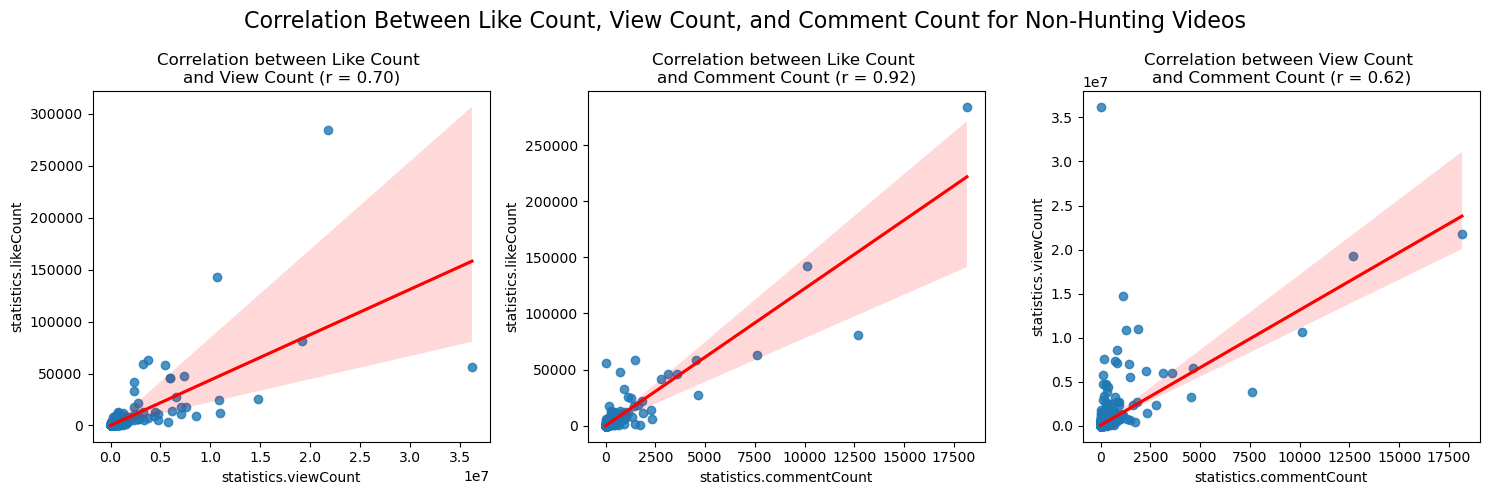

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data points where 'hunt' is False
dets_hunt_false = dets_hunt[dets_hunt['hunt'] == False]

# Calculate correlation coefficients for filtered data
corr1 = dets_hunt_false['statistics.likeCount'].corr(dets_hunt_false['statistics.viewCount'])
corr2 = dets_hunt_false['statistics.likeCount'].corr(dets_hunt_false['statistics.commentCount'])
corr3 = dets_hunt_false['statistics.viewCount'].corr(dets_hunt_false['statistics.commentCount'])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plot with regression line and correlation coefficient for Like Count and View Count
sns.regplot(ax=axes[0], x='statistics.viewCount', y='statistics.likeCount', data=dets_hunt_false, line_kws={'color': 'red'})
axes[0].set_title('Correlation between Like Count \nand View Count (r = {:.2f})'.format(corr1))

# Plot scatter plot with regression line and correlation coefficient for Like Count and Comment Count
sns.regplot(ax=axes[1], x='statistics.commentCount', y='statistics.likeCount', data=dets_hunt_false, line_kws={'color': 'red'})
axes[1].set_title('Correlation between Like Count \nand Comment Count (r = {:.2f})'.format(corr2))

# Plot scatter plot with regression line and correlation coefficient for View Count and Comment Count
sns.regplot(ax=axes[2], x='statistics.commentCount', y='statistics.viewCount', data=dets_hunt_false, line_kws={'color': 'red'})
axes[2].set_title('Correlation between View Count \nand Comment Count (r = {:.2f})'.format(corr3))

# Add overarching title
plt.suptitle('Correlation Between Like Count, View Count, and Comment Count for Non-Hunting Videos', fontsize=16)

# Display plots
plt.tight_layout()
plt.show()


### 2c. Content Categories ###

In [19]:
# Count the number of rows for each categoryID for all data
all_counts = dets_hunt['snippet.categoryId'].value_counts()

# Count the number of rows for each categoryID for hunt data
hunt_counts = dets_hunt[dets_hunt['hunt']]['snippet.categoryId'].value_counts()

# Count the number of rows for each categoryID for not hunt data
not_hunt_counts = dets_hunt[~dets_hunt['hunt']]['snippet.categoryId'].value_counts()

# Create a DataFrame to hold the counts for all, hunt, and not hunt
category_counts = pd.concat([all_counts, not_hunt_counts, hunt_counts], axis=1, sort=True, keys=['All', 'Non-Hunting', 'Hunting'])

# Fill NaN values with 0
category_counts = category_counts.fillna(0)

# Sort the DataFrame by the 'All' column in descending order
category_counts = category_counts.sort_values(by='All', ascending=False)

# Print the category counts by all, hunt, and not hunt
print(category_counts)

import pandas as pd
from scipy.stats import chi2_contingency

# Subset data into hunting and non-hunting categories
dets_hunt_hunt = dets_hunt[dets_hunt['hunt'] == True]
dets_hunt_nonhunt = dets_hunt[dets_hunt['hunt'] == False]

# Create a contingency table
cont_table = pd.crosstab(dets_hunt['snippet.categoryId'], dets_hunt['hunt'])

# Perform the chi-square test
chi2, pval, dof, expected = chi2_contingency(cont_table)

# Print the results
print(' ')
print('Chi-Square Test of Independence')
print('Chi-Square statistic: {:.2f}'.format(chi2))
print('p-value: ',pval)
print('Degrees of freedom: {}'.format(dof))

                        All  Non-Hunting  Hunting
Pets & Animals         1842         1632      210
Travel & Events         616          555       61
Sports                  405          203      202
People & Blogs          262          215       47
Entertainment           202          162       40
Education               166          149       17
Nonprofits & Activism   119          107       12
Film & Animation         78           66       12
Science & Technology     54           52        2
News & Politics          46           40        6
Music                    33           30        3
Howto & Style            28           26        2
Autos & Vehicles         22           18        4
Comedy                   17           16        1
Gaming                    5            3        2
 
Chi-Square Test of Independence
Chi-Square statistic: 415.85
p-value:  5.769577416024428e-80
Degrees of freedom: 14


### 2d. Published Dates ###

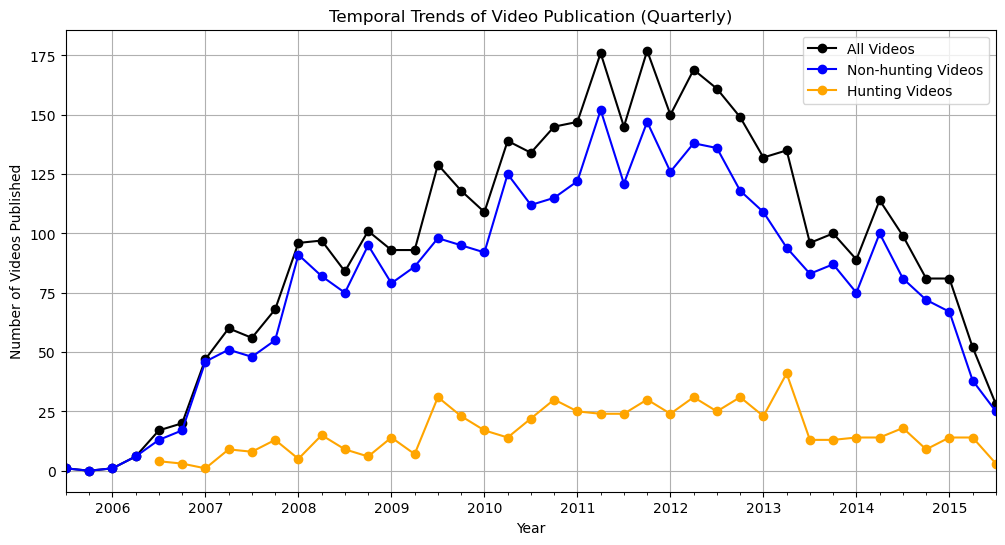

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'snippet.publishedOn' to datetime format
dets_hunt['snippet.publishedOn'] = pd.to_datetime(dets_hunt['snippet.publishedOn'])

# Resample the data to count the number of videos published in each quarter for the overall trend
overall_counts = dets_hunt.resample('Q', on='snippet.publishedOn').size()

# Filter data points where 'hunt' is False and True
dets_hunt_false = dets_hunt[dets_hunt['hunt'] == False]
dets_hunt_true = dets_hunt[dets_hunt['hunt'] == True]

# Resample the data to count the number of videos published in each quarter for hunt=False and hunt=True
hunt_false_counts = dets_hunt_false.resample('Q', on='snippet.publishedOn').size()
hunt_true_counts = dets_hunt_true.resample('Q', on='snippet.publishedOn').size()

# Create the plot
plt.figure(figsize=(12, 6))
overall_counts.plot(marker='o', linestyle='-', color='black', label='All Videos')
hunt_false_counts.plot(marker='o', linestyle='-', color='blue', label="Non-hunting Videos")
hunt_true_counts.plot(marker='o', linestyle='-', color='orange', label="Hunting Videos")

plt.xlabel('Year')
plt.ylabel('Number of Videos Published')
plt.title('Temporal Trends of Video Publication (Quarterly)')
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

### 2e. Mentioned Animals in the Video Titles ###

In [21]:
from collections import Counter

# define a list of animal names
animals = ['dog', 'cat', 'deer', 'bird', 'fish', 'snake', 'rabbit', 'hamster', 'horse', 'turtle', 'lion', 'tiger', 'bear', 'elephant', 'giraffe', 'zebra', 'monkey', 'panda', 'koala', 'kangaroo', 'hippo', 'rhino', 'crocodile', 'alligator', 'shark', 'whale', 'dolphin', 'octopus', 'squid', 'jellyfish']

# tokenize the titles to get a list of words
words = []
for title in translated['title_en']:
    words.extend(nltk.word_tokenize(title.lower()))

# extract the animal names
animal_names = []
for word in words:
    if word.endswith('s'):
        word = word[:-1]
    if word in animals:
        animal_names.append(word)

# count the frequency of each animal name
animal_counts = Counter(animal_names)

# get the list of animal names in descending order of frequency
animals_ordered = animal_counts.most_common()

In [22]:
import nltk
from collections import Counter

# Filter data points where 'hunt' is False and True
dets_hunt_false = dets_hunt[dets_hunt['hunt'] == False]
dets_hunt_true = dets_hunt[dets_hunt['hunt'] == True]

def animal_frequency(df):
    animals = ['dog', 'cat', 'deer', 'bird', 'fish', 'snake', 'rabbit', 'hamster', 'horse', 'turtle', 'lion', 'tiger', 'bear', 'elephant', 'giraffe', 'zebra', 'monkey', 'panda', 'koala', 'kangaroo', 'hippo', 'rhino', 'crocodile', 'alligator', 'shark', 'whale', 'dolphin', 'octopus', 'squid', 'jellyfish']

    words = []
    for title in df['title_en']:
        words.extend(nltk.word_tokenize(title.lower()))

    animal_names = []
    for word in words:
        if word.endswith('s'):
            word = word[:-1]
        if word in animals:
            animal_names.append(word)

    animal_counts = Counter(animal_names)
    animals_ordered = animal_counts.most_common()
    return animals_ordered

# Calculate animal frequency for 'hunt' is False and True
hunt_false_animals = animal_frequency(dets_hunt_false)
hunt_true_animals = animal_frequency(dets_hunt_true)

In [23]:
import pandas as pd

# Convert the animal frequencies to DataFrames
animals_ordered_df = pd.DataFrame(animals_ordered, columns=['Animal', 'All Videos'])
hunt_false_animals_df = pd.DataFrame(hunt_false_animals, columns=['Animal', 'Non-hunting Videos'])
hunt_true_animals_df = pd.DataFrame(hunt_true_animals, columns=['Animal', 'Hunting Videos'])

# Merge the DataFrames
merged_df = animals_ordered_df.merge(hunt_false_animals_df, on='Animal', how='outer').merge(hunt_true_animals_df, on='Animal', how='outer')
merged_df = merged_df.fillna(0)
merged_df['Hunting Videos'] = merged_df['Hunting Videos'].astype(int)

merged_df

,Animal,All Videos,Non-hunting Videos,Hunting Videos
0,elephant,175,171,4
1,bear,174,147,27
2,lion,145,127,18
3,tiger,144,143,1
4,deer,132,68,64
5,cat,107,100,7
6,bird,105,102,3
7,dog,53,45,8
8,rabbit,33,30,3
9,giraffe,29,3,26
